In [31]:
#Richard Woo, Melody Griffith, and Kaleb Cole-Wood
#ECE 134, Project 1

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy
import time
import random
start_time = time.time();

In [12]:
## This code collects the map partitions to produce a single array. There is only one map included in this project.
map_total = np.zeros((810,1210));
for i in range(10):
    for j in range(10):
        img_name = 'row-' + str(i + 1) + '-column-' + str(j + 1) + '.png';
        img = Image.open(img_name);
        #below line added from campuswire suggestion
        img = img.crop((0,0,121,81));
        img = img.convert('L');
        img = np.asarray(img)/255;
        map_total[81*i:81*(i+1),121*j:121*(j+1)] = img;

#Test with reduced size map for quicker code
map_red = map_total[:300, :300];

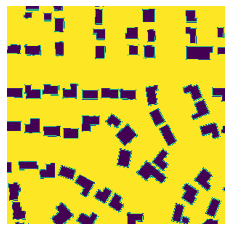

In [13]:
#Plot reduced size map
plt.imshow(map_red)
plt.axis("off")
plt.show()

In [14]:
#Inputs are two tuples, returns the distance between the two points
def getDistance( pt1, pt2 ):
    #Shortest distance between two points on a 2D plane
    return ((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)**(0.5);

#Inputs are two tuples for the coordinate points and the map matrix
def isObstructed( pt1, pt2, map):
    #check if points are obstructed...
    if (map[pt1] == 0 or map[pt2] == 0):
        return -1;
    #arrange points in order from left to right
    if (pt1[0] <= pt2[0]):
        pts = [pt1, pt2];
    else:
        pts = [pt2, pt1];
    ## Check for cases of horizontal or vertical paths
    #Vertical
    if (pts[0][0] == pts[1][0]):
        #Need to iterate upwards in order for the range() function to work properly
        rng = [min(pts[0][1], pts[1][1]), max(pts[0][1], pts[1][1])];
        #Skip the case where two points are adjacent, as there cannot be any obstructions
        if (rng[1] - rng[0] > 1):
            i = pts[0][0];
            for j in range(rng[0] + 1, rng[1]):
                if (map[i, j] == 0):
                    return True;
        return False;
    #Horizontal
    elif (pts[0][1] == pts[1][1]):
        #already ordered points from left to right
        rng = [pts[0][0], pts[1][0]];
        #Skip the case where two points are adjacent, as there cannot be any obstructions
        if (rng[1] - rng[0] > 1):
            j = pts[0][1];
            for i in range(rng[0] + 1, rng[1]):
                if (map[i, j] == 0):
                    return True;
        return False;
    ## Otherwise, we can calculate the slope and search for obstructions
    #slope
    m = (pts[1][1] - pts[0][1])/(pts[1][0] - pts[0][0]);
    #calculate y intercept heights at boundaries between columns
    checks = np.linspace((pts[0][1] - 0.5) + (0.5*m), (pts[1][1] - 0.5) + ((-0.5)*m), pts[1][0] - pts[0][0]);
    checks = checks.tolist();
    #Add starting and ending points to account for starting and ending columns
    checks.insert(0, (pts[0][1] - 0.5));
    checks.insert(len(checks), (pts[1][1] - 0.5));
    #Set starting column
    x0 = pts[0][0];
    #Iterate through each column as a pair of y intercept heights
    for i in range(len(checks) - 1):
        #Need different adjustments based on positive or negative slope in the case where 
        #the line passes through a corner of a square
        if (m > 0):
            #Iterate upwards through current column x0 + i
            for j in range(math.floor(checks[i]) + 1, math.ceil(checks[i + 1]) + 1):
                if (map[x0 + i, j] == 0):
                    return True;
        else:
            #Iterate upwards through current column x0 + i
            for j in range(math.floor(checks[i + 1]) + 1, math.ceil(checks[i]) + 1):
                if (map[x0 + i, j] == 0):
                    return True;
    return False;

#Inputs are two tuples for the coordinate points and the map matrix
def getConnectivity( pt1, pt2, map ):
    obstruction = isObstructed(pt1, pt2, map);
    #If either pt1 or pt2 is obstructed, this is an error, cannot place sensor here
    if obstruction == -1:
        return -1;
    connectivity = 0;
    #Calculate distance between pt1 and pt2
    d = getDistance(pt1, pt2);
    #Adjust conenctivity formula based on whether the two points are obstructed or not
    if obstruction:
        connectivity = math.log(1 + (10**4)/max(1, (d**4)), 2);
    else:
        connectivity = math.log(1 + (10**4)/max(1, (d**2)), 2);
    return connectivity;

In [15]:
## Function for Notions 1 and 2

#Calculates edge with min connectivity on path from node_of_interest to sink
def find_min_connectivity(nodes, node_of_interest):
    min_con = math.inf;
    while (node_of_interest > 0):
        parent_con = nodes[node_of_interest]["con_parent"];
        #check connectivity with parent
        if (parent_con < min_con):
            min_con = parent_con;
        node_of_interest = nodes[node_of_interest]["parent"]; #set up for next check of connectivity
    return min_con;

#Calculates min connectivity on path to sink for each sensor node
def get_min_cuts(nodes):
    min_cuts = [];
    for i in range(1, len(nodes)):
        min_cuts.append(find_min_connectivity(nodes, i));
    return min_cuts;

## Funciton for Notion 1
def worst_min_cut(nodes):
    return min(get_min_cuts(nodes));

## Function for Notion 2
def avg_min_cuts(nodes):
    return np.average(get_min_cuts(nodes));

## Functions for Notion 3
def subtree_size(nodes, node_of_interest):
    counter = 1;
    children_of_interest = nodes[node_of_interest]["children"];
    num_children = len(children_of_interest);
    if num_children == 0:
        return 1;
    for i in range(len(children_of_interest)):
        counter = counter + subtree_size(nodes, children_of_interest[i]);
    return counter;

def min_unicast(nodes):
    min_cut = math.inf;
    min_cut_node = -1;
    for i in range(len(nodes)):
        if i == 0:
            pass;
        else:
            this_cut = (nodes[i]["con_parent"])/subtree_size(nodes, i);
            if this_cut < min_cut:
                min_cut = this_cut;
                min_cut_node = i;
    return (min_cut, min_cut_node);

In [16]:
## Calculation of coverage

#Returns the percentage of map covered by the sensor nodes in list nodes
def area_coverage(nodes, map):
    map_size = np.shape(map);
    coverage_map = np.zeros(map_size);
    x_max = map_size[0] - 1;
    y_max = map_size[1] - 1;
    for i in range(len(nodes)):
        if i == 0:
            pass;
        else:
            node_loc = nodes[i]["loc"];
            for x in range(node_loc[0] - 4, node_loc[0] + 5):
                for y in range(node_loc[1] - 4, node_loc[1] + 5):
                    if (x >= 0 and y >= 0 and x <= x_max and y <= y_max and coverage_map[x, y] == 0 and map[x, y] == 1):
                        coverage_map[x, y] = 1;
    return np.sum(coverage_map)/np.sum(map);

In [17]:
## Graphing Function
def graph_set(x_range, y_values, y_label, title):
    plt.plot(x_range,y_values);
    plt.xlabel('Number of Nodes in Graph');
    plt.ylabel(y_label);
    plt.title(title);
    #plt.show();
    return;

In [18]:
## Algorithm Helper Functions

def function_4(map, map_n):
    added_node = False;
    loc_to_add = -1;
    map_size = np.shape(map);
    x_size = map_size[0];
    y_size = map_size[1];
    
    for x in range(x_size):
        for y in range(y_size):
            
            if (map_n[x, y] == 3):
                if ((x - 8 < x_size) and (y + 8 < y_size) and (x - 8 >= 0) and (y + 8 >= 0) and map[x - 8, y + 8] == 1) \
                        and (map_n[x - 8, y + 8] != 3) and (map_n[x - 8, y + 8] != 5):
                    map_n[x - 8, y + 8] = 4;
                if ((x + 8 < x_size) and (y + 8 < y_size) and (x + 8 >= 0) and (y + 8 >= 0) and map[x + 8, y + 8] == 1) \
                        and (map_n[x + 8, y + 8] != 3) and (map_n[x + 8, y + 8] != 5):
                    map_n[x + 8, y + 8] = 4;
                if ((x + 8 < x_size) and (y - 8 < y_size) and (x + 8 >= 0) and (y - 8 >= 0) and map[x + 8, y - 8] == 1) \
                        and (map_n[x + 8, y - 8] != 3) and (map_n[x + 8, y - 8] != 5):
                    map_n[x + 8, y - 8] = 4;
                if ((x - 8 < x_size) and (y - 8 < y_size) and (x - 8 >= 0) and (y - 8 >= 0) and map[x - 8, y - 8] == 1) \
                        and (map_n[x - 8, y - 8] != 3) and (map_n[x - 8, y - 8] != 5):
                    map_n[x - 8, y - 8] = 4;
                    
                if ((x - 8 < x_size) and (y < y_size) and (x - 8 >= 0) and (y >= 0) and map[x - 8, y] == 1) \
                        and (map_n[x - 8, y] != 3) and (map_n[x - 8, y] != 5):
                    map_n[x - 8, y] = 4;
                if ((x + 8 < x_size) and (y < y_size) and (x + 8 >= 0) and (y >= 0) and map[x + 8, y] == 1) \
                        and (map_n[x + 8, y] != 3) and (map_n[x + 8, y] != 5):
                    map_n[x + 8, y] = 4;
                
                map_n[x, y] = 5;
            
            if (map_n[x, y] == 4 and added_node == False):
                for i in range(9):
                    for j in range(9):
                        if ((x - 4 + i < x_size) and (y - 4 + j < y_size) and map_n[x - 4 + i, y - 4 + j] != 3 \
                                and map_n[x - 4 + i, y - 4 + j] != 5 and map[x - 4 + i, y - 4 + j] != 0):
                            map_n[x - 4 + i, y - 4 + j] = 2;
                map_n[x, y] = 3;
                loc_to_add = (x, y);
                added_node = True;
    if (added_node == False):
        for x in range(x_size):
            if (added_node == False):
                for y in range(y_size):
                    if (map_n[x, y] == 1):
                        map_n[x, y] = 3;
                        loc_to_add = (x, y);
                        added_node = True;
                        break;
            else:
                break;
    return (map_n, loc_to_add);

In [19]:
def add_nodes(n_nodes, map):
    # write a function that adds n_nodes sensor nodes to cover the map based on your algorithm
    
    #Set up spanning tree as list of sensor dictionaries
    nodes = [];
    
    #Define algorithm helper map
    helper_map = copy.copy(map);
    
    #add sink
    map_size = np.shape(map);
    center = (int(map_size[0]/2), int(map_size[0]/2));
    n0 = {"parent": -1, "children": [], "loc": center, "con_parent": -1};
    nodes.append(n0);
    helper_map[center] = 3;
    
    for i in range(n_nodes):
        nodes.append(add_one_node(nodes, map, helper_map));
        nodes[nodes[len(nodes) - 1]["parent"]]["children"].append(len(nodes) - 1);        
    
    # connectivity = list of three discussed notions of connectivity on your final constructed tree
    # coverage = percantage of area you covered from the map
    connectivity = (worst_min_cut(nodes), avg_min_cuts(nodes), min_unicast(nodes)[0]);
    coverage = area_coverage(nodes, map);
    return (connectivity, coverage);

def add_one_node(nodes, map, helper_map):
    # write a function that adds one sensor node, given previously added nodes and the map, based on your algorithm
    
    #Call helper function
    result_4 = function_4(map, helper_map);
    helper_map = result_4[0];
    loc = result_4[1];
    if (loc == -1):
        return -1;
    
    ## add node
    max_link = 0;
    max_link_index = -1;
    for i in range(len(nodes)):
        this_link = getConnectivity(loc, nodes[i]["loc"], map);
        if (this_link > max_link):
            max_link = this_link;
            max_link_index = i;
    
    parent = max_link_index;
    conn = max_link;

    #Create new node
    added_node = {"parent": parent, "children": [], "loc": loc, "con_parent": conn};

    ## update connectivity graph and tree
    update_graph(added_node, map);

    return added_node;

def update_graph(node, map):
    # write a function that creates and updates the connectivity graph and corresponding maximum weight spanning tree
    return True;

# You can choose any data structure you think best to represent nodes, graphs, and any other data types.

In [ ]:
## Start of Main function (Main Pt 1)

sensor_range = list(range(10, 1801, 10));
print(sensor_range);
y_conn_1 = np.zeros(len(sensor_range));
y_conn_2 = np.zeros(len(sensor_range));
y_conn_3 = np.zeros(len(sensor_range));
y_coverage = np.zeros(len(sensor_range));

for i in range(len(sensor_range)):
    this_time = time.time();
    result = add_nodes(sensor_range[i], map_red);
    this_connectivity = result[0];
    this_coverage = result[1];
    y_conn_1[i] = this_connectivity[0];
    y_conn_2[i] = this_connectivity[1];
    y_conn_3[i] = this_connectivity[2];
    y_coverage[i] = this_coverage;
    print("Finished Running with ", sensor_range[i], " sensors in ", time.time() - this_time, " seconds.");

In [25]:
## find minimum number of nodes to provide at minimum 90% connectivity (Main Pt 2)
min_num_sensors = math.inf;
coverage = 0;
for i in range(len(y_coverage)):
    coverage = y_coverage[i];
    if y_coverage[i] >= .9:
        min_num_sensors = sensor_range[i];
        break;

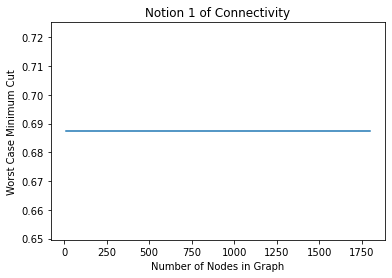

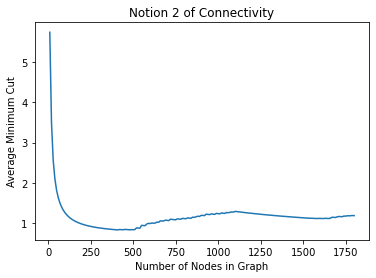

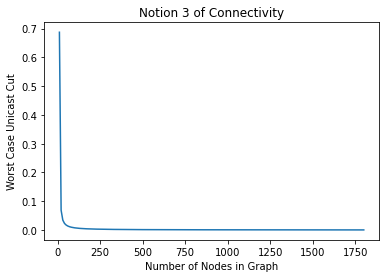

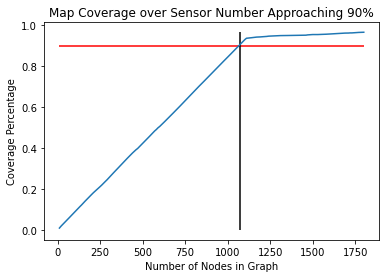

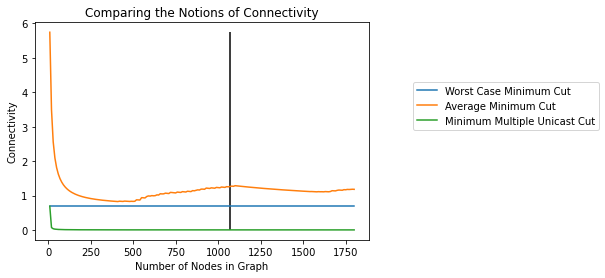

Minimum number of sensors to achieve 90% connectivity: 1070 
 Coverage achieved: 0.903288042362793


Program took  36495.84700989723  seconds, or  608.2641168316205  minutes, or  10.137735280527009  hours to run  180  different sensor quantities.


In [29]:
## plot the number of sensors vs connectivity for different number of sensors (Main Pt 3)
graph_set(sensor_range, y_conn_1, "Worst Case Minimum Cut", "Notion 1 of Connectivity");
plt.show();
graph_set(sensor_range, y_conn_2, "Average Minimum Cut", "Notion 2 of Connectivity");
plt.show();
graph_set(sensor_range, y_conn_3, "Worst Case Unicast Cut", "Notion 3 of Connectivity");
plt.show();
graph_set(sensor_range, y_coverage, "Coverage Percentage", "Map Coverage over Sensor Number Approaching 90%");
plt.hlines(0.9, min(sensor_range), max(sensor_range), color='red', linestyle = "solid");
plt.vlines(min_num_sensors, 0, max(y_coverage), color = 'black', linestyle = 'solid');
plt.show();

#plot all connectivities together with 90% coverage
plt.plot(sensor_range,y_conn_1); #
plt.plot(sensor_range,y_conn_2);
plt.plot(sensor_range,y_conn_3);
plt.vlines(min_num_sensors, 0, max(max(y_conn_1), max(y_conn_2), max(y_conn_3)), color = 'black', linestyle = 'solid');
plt.xlabel('Number of Nodes in Graph');
plt.ylabel('Connectivity');
plt.legend(['Worst Case Minimum Cut', 'Average Minimum Cut', "Minimum Multiple Unicast Cut"], bbox_to_anchor =(1.7, 0.75));
plt.title('Comparing the Notions of Connectivity'); 
plt.show();
            
print('Minimum number of sensors to achieve 90% connectivity:', min_num_sensors, '\n Coverage achieved:', coverage);

print('\n');
t = time.time() - start_time;
print("Program took ", t, " seconds, or ", t/60, " minutes, or ", t/(60*60), " hours to run ", \
      len(sensor_range), " different sensor quantities.");

In [32]:
## Uniform Random placement method (Main Pt 4)
#Define uniformly spaced points, which would maximally cover the map
#Note that we will skip spots along the uniform distribution that are obstructed.
# These spots will not be made up for because it is a uniform distribution
#We will randomly select points along the uniform distribution to add them to the tree

#Create uniform points in range of our map
def get_uniform_pts (map):
    pts = [];
    map_shape = np.shape(map);
    x_max = map_shape[0];
    y_max = map_shape[1];
    for i in range(4, x_max, 9):
        for j in range(4, y_max, 9):
            pts.append((i, j));
    return pts;

uniform_pts = get_uniform_pts(map_red);
num_spots = len(uniform_pts);
#Get random placement array
rand_indices = random.sample(range(num_spots), num_spots);
rand_nodes = [];
#Add sink
map_size = np.shape(map_red);
center = (int(map_size[0]/2), int(map_size[0]/2));
n0 = {"parent": -1, "children": [], "loc": center, "con_parent": -1};
rand_nodes.append(n0);
#Add all other nodes randomly
y_conn_1_rand = [];
y_conn_2_rand = [];
y_conn_3_rand = [];
y_coverage_rand = [];
for i in range(num_spots):
    this_pt = uniform_pts[rand_indices[i]];
    if (this_pt != center and map_red[this_pt] == 1):
        #Find node to add this_pt to
        rand_max_link = 0;
        rand_max_link_index = -1;
        for i in range(len(rand_nodes)):
            rand_this_link = getConnectivity(this_pt, rand_nodes[i]["loc"], map_red);
            if (rand_this_link > rand_max_link):
                rand_max_link = rand_this_link;
                rand_max_link_index = i;

        rand_parent = rand_max_link_index;
        rand_conn = rand_max_link;
        
        #Add node and update spanning tree
        rand_added_node = {"parent": rand_parent, "children": [], \
                           "loc": this_pt, "con_parent": rand_conn};
        rand_nodes.append(rand_added_node);
        rand_nodes[rand_nodes[len(rand_nodes) - 1]["parent"]]["children"].append(len(rand_nodes) - 1);
        
        #Update connectivity arrays and check coverage to see if we can stop
        y_conn_1_rand.append(worst_min_cut(rand_nodes));
        y_conn_2_rand.append(avg_min_cuts(rand_nodes));
        y_conn_3_rand.append(min_unicast(rand_nodes)[0]);
        y_coverage_rand.append(area_coverage(rand_nodes, map_red));
        if (y_coverage_rand[len(y_coverage_rand) - 1] > 0.9):
            break;

sensor_range_rand = range(1, len(y_conn_1_rand) + 1);
min_num_sensors_rand = sensor_range_rand[len(sensor_range_rand) - 1];
coverage_rand = y_coverage_rand[len(y_coverage_rand) - 1];

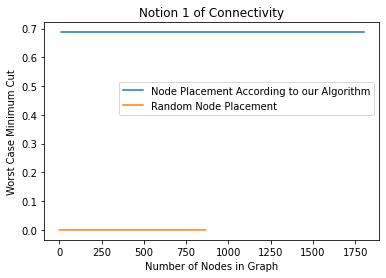

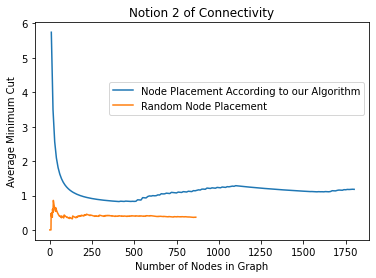

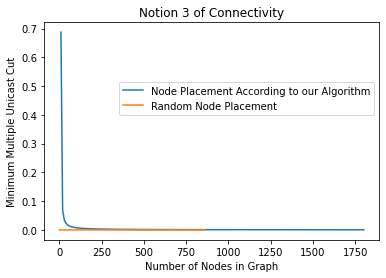

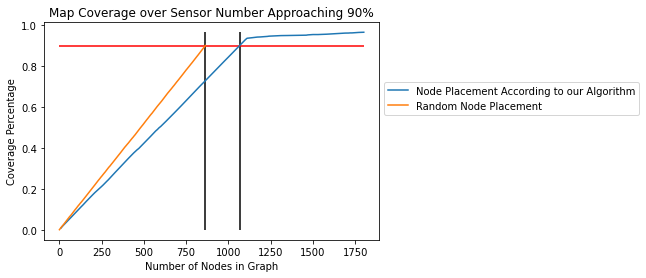

Minimum number of sensors to achieve 90% connectivity using our algorithm: 1070 
 Coverage achieved: 0.903288042362793
Minimum number of sensors to achieve 90% connectivity using random algorithm: 864 
 Coverage achieved: 0.900565110901304


In [33]:
## Main Pt 5 - Plots

#notion 1 of connectivity
plt.plot(sensor_range,y_conn_1);
plt.plot(sensor_range_rand,y_conn_1_rand);
plt.xlabel('Number of Nodes in Graph');
plt.ylabel('Worst Case Minimum Cut');
plt.legend(['Node Placement According to our Algorithm', 'Random Node Placement'], \
           bbox_to_anchor =(1, 0.75));
plt.title('Notion 1 of Connectivity');
plt.show();

#notion 2 of connectivity
plt.plot(sensor_range,y_conn_2);
plt.plot(sensor_range_rand,y_conn_2_rand);
plt.xlabel('Number of Nodes in Graph');
plt.ylabel('Average Minimum Cut');
plt.legend(['Node Placement According to our Algorithm', 'Random Node Placement'], \
           bbox_to_anchor =(1, 0.75));
plt.title('Notion 2 of Connectivity');
plt.show();

#notion 3 of connectivity
plt.plot(sensor_range,y_conn_3);
plt.plot(sensor_range_rand,y_conn_3_rand);
plt.xlabel('Number of Nodes in Graph');
plt.ylabel('Minimum Multiple Unicast Cut');
plt.legend(['Node Placement According to our Algorithm', 'Random Node Placement'], \
           bbox_to_anchor =(1, 0.75));
plt.title('Notion 3 of Connectivity');
plt.show();

#coverage
plt.plot(sensor_range, y_coverage);
plt.plot(sensor_range_rand, y_coverage_rand);
plt.vlines(min_num_sensors, 0, max(max(y_coverage), max(y_coverage_rand)), \
           color = 'black', linestyle = 'solid');
plt.vlines(min_num_sensors_rand, 0, max(max(y_coverage), max(y_coverage_rand)), \
           color = 'black', linestyle = 'solid');
plt.hlines(0.9, min(min(sensor_range), min(sensor_range_rand)), \
           max(max(sensor_range), max(sensor_range_rand)), color = 'red', linestyle = 'solid');
plt.xlabel('Number of Nodes in Graph');
plt.ylabel('Coverage Percentage');
plt.legend(['Node Placement According to our Algorithm', 'Random Node Placement'], bbox_to_anchor =(1, 0.75));
plt.title('Map Coverage over Sensor Number Approaching 90%');
plt.show();

print('Minimum number of sensors to achieve 90% connectivity using our algorithm:', \
      min_num_sensors, '\n Coverage achieved:', coverage);
print('Minimum number of sensors to achieve 90% connectivity using random algorithm:', \
      min_num_sensors_rand, '\n Coverage achieved:', coverage_rand);

In [34]:
## Calculation of trivial lower bound for sensors (Main Pt 6)
print("Trivially, any algorithm would need at least", np.sum(map_red)*0.9/81, \
      "sensors to cover 90% of the reduced size map.");

Trivially, any algorithm would need at least 812.0333333333333 sensors to cover 90% of the reduced size map.


Question: What is the minimum number of sensors required to cover $90\%$ of the map?

Answer: A trivial lower bound would put us at 812 sensors to cover 90% of the reduced size map. Practically, our algorithm requires around 1070 sensors to cover 90% of the map. The uniform random placement method uses 864 sensors to cover 90% of the map.